In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ecommerce-data/data.csv


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
import datetime as dt
from operator import attrgetter
import matplotlib.colors as mcolors
import plotly.graph_objs as go
from plotly.offline import iplot
from sklearn.metrics import (silhouette_score,
                             calinski_harabasz_score,
                             davies_bouldin_score)

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_samples, silhouette_score

sns.set(style="whitegrid")

from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import warnings
warnings.filterwarnings('ignore')

In [3]:
df_sale = pd.read_csv('/kaggle/input/ecommerce-data/data.csv',encoding="ISO-8859-1")

In [4]:
df_sale.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [5]:
df_sale.shape

(541909, 8)

In [6]:
df_sale.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [7]:
df_sale.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


In [8]:
df_sale.describe(include='object').T

,count,unique,top,freq
InvoiceNo,541909,25900,573585,1114
StockCode,541909,4070,85123A,2313
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369
InvoiceDate,541909,23260,10/31/2011 14:41,1114
Country,541909,38,United Kingdom,495478


In [9]:
df_sale["Country"].value_counts(normalize=True)

Country
United Kingdom          0.914320
Germany                 0.017521
France                  0.015790
EIRE                    0.015124
Spain                   0.004674
Netherlands             0.004375
Belgium                 0.003818
Switzerland             0.003694
Portugal                0.002803
Australia               0.002323
Norway                  0.002004
Italy                   0.001482
Channel Islands         0.001399
Finland                 0.001283
Cyprus                  0.001148
Sweden                  0.000853
Unspecified             0.000823
Austria                 0.000740
Denmark                 0.000718
Japan                   0.000661
Poland                  0.000629
Israel                  0.000548
USA                     0.000537
Hong Kong               0.000531
Singapore               0.000423
Iceland                 0.000336
Canada                  0.000279
Greece                  0.000269
Malta                   0.000234
United Arab Emirates    0.000125
Eu

In [10]:
df_sale["InvoiceNo"] = df_sale.InvoiceNo.astype("str")
df_sale["Description"] = df_sale.Description.astype("str")
df_sale["Description"] = df_sale.Description.str.strip()

In [11]:
null_percentage = df_sale.isnull().mean() * 100


In [12]:
df_sale = df_sale.dropna(subset=["CustomerID"])


In [13]:
df_sale.isnull().mean() * 100 

InvoiceNo      0.0
StockCode      0.0
Description    0.0
Quantity       0.0
InvoiceDate    0.0
UnitPrice      0.0
CustomerID     0.0
Country        0.0
dtype: float64

In [14]:
duplicates = df_sale.duplicated()
duplicates.sum()

5225

In [15]:
df_sale[duplicates]


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,12/1/2010 11:45,2.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
555,536412,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1,12/1/2010 11:49,2.95,17920.0,United Kingdom
...,...,...,...,...,...,...,...,...
541675,581538,22068,BLACK PIRATE TREASURE CHEST,1,12/9/2011 11:34,0.39,14446.0,United Kingdom
541689,581538,23318,BOX OF 6 MINI VINTAGE CRACKERS,1,12/9/2011 11:34,2.49,14446.0,United Kingdom
541692,581538,22992,REVOLVER WOODEN RULER,1,12/9/2011 11:34,1.95,14446.0,United Kingdom
541699,581538,22694,WICKER STAR,1,12/9/2011 11:34,2.10,14446.0,United Kingdom


In [16]:
df_sale = df_sale.drop_duplicates()


df_sale.reset_index(drop=True, inplace=True)


In [17]:
df_sale

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
401599,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
401600,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
401601,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
401602,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


In [18]:
df_sale["is_Cancelled"] = df_sale["InvoiceNo"].apply(lambda x: True if x.startswith('C') else False)


In [19]:
df_sale["is_Cancelled"].value_counts(normalize=True)


is_Cancelled
False    0.977909
True     0.022091
Name: proportion, dtype: float64

In [20]:
df_sale[
    df_sale["is_Cancelled"]
].describe().drop('CustomerID', axis=1).T

,count,mean,std,min,25%,50%,75%,max
Quantity,8872.0,-30.774910,1172.249902,-80995.00,-6.00,-2.00,-1.00,-1.0
UnitPrice,8872.0,18.899512,445.190864,0.01,1.45,2.95,4.95,38970.0


In [21]:
fig_quantity = px.box(df_sale, y="Quantity", notched=True, title="Box Plot of Quantity")
fig_quantity.show()

In [22]:
fig_quantity = px.box(df_sale[~df_sale["is_Cancelled"]], y="Quantity", notched=True, title="Box Plot of Quantity")
fig_quantity.show()

In [23]:
# Box plot for Quantity
fig_quantity = px.box(df_sale[~df_sale["is_Cancelled"]], y="Quantity", notched=True, title="Box Plot of Quantity")
fig_quantity.show()

In [24]:
# Box plot for Quantity
fig_quantity = px.box(df_sale[~df_sale["is_Cancelled"]], y="Quantity", notched=True, title="Box Plot of Quantity", log_y=True)
fig_quantity.show()

In [25]:
rfm = df_sale

In [26]:
print(df_sale['InvoiceDate'].max())

9/9/2011 9:52


In [27]:
def replace_with_thresholds(dataframe, variable, q1 = 0.25, q3 = 0.75):
    
    '''
    Detects outliers with IQR method and replaces with thresholds 
    
    '''
    
    df_ = dataframe.copy()
    quartile1 = df_[variable].quantile(q1)
    quartile3 = df_[variable].quantile(q3)
    iqr = quartile3 - quartile1
    
    up_limit = quartile3 + 1.5 * iqr
    low_limit = quartile1 - 1.5 * iqr
    df_.loc[(df_[variable] < low_limit), variable] = low_limit
    df_.loc[(df_[variable] > up_limit), variable] = up_limit
    
    return df_

In [28]:
def ecommerce_preprocess(dataframe):
    df_ = dataframe.copy()
    
    #Missing Values
    df_ = df_.dropna()
    
    #Cancelled Orders & Quantity
    df_ = df_[~df_['InvoiceNo'].str.contains('C', na = False)]
    df_ = df_[df_['Quantity'] > 0]
    
    #Replacing Outliers
    df_ = replace_with_thresholds(df_, "Quantity", q1 = 0.01, q3 = 0.99)
    df_ = replace_with_thresholds(df_, "UnitPrice", q1 = 0.01, q3 = 0.99)
    
    #Total Price
    df_["TotalPrice"] = df_["Quantity"] * df_["UnitPrice"]
    
    return df_

In [29]:
df1 = ecommerce_preprocess(df_sale)

In [30]:
df1.dtypes

InvoiceNo        object
StockCode        object
Description      object
Quantity        float64
InvoiceDate      object
UnitPrice       float64
CustomerID      float64
Country          object
is_Cancelled       bool
TotalPrice      float64
dtype: object

In [31]:
df_sale

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,is_Cancelled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,False
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,False
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,False
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,False
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,False
...,...,...,...,...,...,...,...,...,...
401599,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France,False
401600,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France,False
401601,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France,False
401602,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France,False


In [32]:
df_sale["len_StockCode"] = df_sale["StockCode"].str.strip().str.len()


In [33]:
df_sale["len_StockCode"].value_counts(normalize=True)


len_StockCode
5     0.911791
6     0.082703
4     0.003028
1     0.001337
7     0.000737
2     0.000334
3     0.000040
12    0.000030
Name: proportion, dtype: float64

In [34]:
df_sale[
    df_sale["len_StockCode"] == 5
]["StockCode"].nunique()

2798

In [35]:
df_sale[
    df_sale["len_StockCode"] < 5
]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,is_Cancelled,len_StockCode
45,536370,POST,POSTAGE,3,12/1/2010 8:45,18.00,12583.0,France,False,4
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom,True,1
386,536403,POST,POSTAGE,1,12/1/2010 11:27,15.00,12791.0,Netherlands,False,4
1097,536527,POST,POSTAGE,1,12/1/2010 13:04,18.00,12662.0,Germany,False,4
1386,536540,C2,CARRIAGE,1,12/1/2010 14:05,50.00,14911.0,EIRE,False,2
...,...,...,...,...,...,...,...,...,...,...
401195,581494,POST,POSTAGE,2,12/9/2011 10:13,18.00,12518.0,Germany,False,4
401243,C581499,M,Manual,-1,12/9/2011 10:28,224.69,15498.0,United Kingdom,True,1
401425,581570,POST,POSTAGE,1,12/9/2011 11:59,18.00,12662.0,Germany,False,4
401462,581574,POST,POSTAGE,2,12/9/2011 12:09,18.00,12526.0,Germany,False,4


In [36]:
df_sale[
    df_sale["len_StockCode"] < 5
]["StockCode"].value_counts(normalize=True)

StockCode
POST    0.628481
M       0.241724
C2      0.070415
D       0.040462
DOT     0.008408
CRUK    0.008408
PADS    0.002102
Name: proportion, dtype: float64

In [37]:
df_sale[
    df_sale["len_StockCode"] > 7
]["StockCode"].value_counts(normalize=True)

StockCode
BANK CHARGES    1.0
Name: proportion, dtype: float64

In [38]:
df_sale[
    (df_sale["len_StockCode"] >= 5) & (df_sale["len_StockCode"] < 8)
]["StockCode"].nunique()

3676

In [39]:
df_sale[
    (df_sale["len_StockCode"] >= 5) & (df_sale["len_StockCode"] < 8)
].shape

(399689, 10)

In [40]:
df_sale = df_sale[
    (df_sale["len_StockCode"] >= 5) & (df_sale["len_StockCode"] < 8)
]

In [41]:
# Convert InvoiceDate to datetime and set as index
df_sale['InvoiceDate'] = pd.to_datetime(df_sale['InvoiceDate'])
viz_data = df_sale.set_index('InvoiceDate')

# Aggregate sales data
viz_data['Sales'] = viz_data['Quantity'] * viz_data['UnitPrice']
daily_sales = viz_data['Sales'].resample('D').sum()  # 'D' for daily

In [42]:
# Time Series Plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=daily_sales.index, y=daily_sales, mode='lines', name='Sales'))
fig.update_layout(title='Daily Sales Over Time', xaxis_title='Date', yaxis_title='Sales')
fig.show()

In [43]:
decomposition = seasonal_decompose(daily_sales.dropna(), model='additive')  # Assuming yearly seasonality

# Plot the decomposed components using Plotly
# Note that we use the .observed, .trend, .seasonal, and .resid attributes of the decomposition object
fig = make_subplots(rows=4, cols=1, shared_xaxes=True,
                    subplot_titles=('Observed', 'Trend', 'Seasonal', 'Residual'))

fig.append_trace(go.Scatter(x=daily_sales.index, y=decomposition.observed, mode='lines', name='Observed'), row=1, col=1)
fig.append_trace(go.Scatter(x=daily_sales.index, y=decomposition.trend, mode='lines', name='Trend'), row=2, col=1)
fig.append_trace(go.Scatter(x=daily_sales.index, y=decomposition.seasonal, mode='lines', name='Seasonal'), row=3, col=1)
fig.append_trace(go.Scatter(x=daily_sales.index, y=decomposition.resid, mode='lines', name='Residual'), row=4, col=1)

fig.update_layout(title='Time Series Decomposition')
fig.show()

In [44]:
monthly_sales = viz_data['Sales'].resample('ME').sum()

# Plot Monthly Sales
fig = go.Figure([go.Scatter(x=monthly_sales.index, y=monthly_sales)])
fig.update_layout(title='Monthly Sales Over Time', xaxis_title='Month', yaxis_title='Sales')
fig.show()

**RFM Analysis**

RFM stands for Recency, Frequency, and Monetary value, each corresponding to some key customer trait. These RFM metrics are important indicators of a customer’s behavior because frequency and monetary value affects a customer’s lifetime value, and recency affects retention, a measure of engagement.

RFM factors illustrate these facts:

* The more recent the purchase, the more responsive the customer is to promotions
* The more frequently the customer buys, the more engaged and satisfied they are
* Monetary value differentiates heavy spenders from low-value purchasers



In [45]:
viz_data

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,is_Cancelled,len_StockCode,Sales
InvoiceDate,,,,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,False,6,15.30
2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,False,5,20.34
2010-12-01 08:26:00,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,False,6,22.00
2010-12-01 08:26:00,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,False,6,20.34
2010-12-01 08:26:00,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,False,6,20.34
...,...,...,...,...,...,...,...,...,...,...
2011-12-09 12:50:00,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,0.85,12680.0,France,False,5,10.20
2011-12-09 12:50:00,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2.10,12680.0,France,False,5,12.60
2011-12-09 12:50:00,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,4.15,12680.0,France,False,5,16.60


In [46]:
df_sale["Monetary"] = df_sale["Quantity"] * df_sale["UnitPrice"]

df_sale["InvoiceDate"] = pd.to_datetime(df_sale["InvoiceDate"])


current_date = df_sale["InvoiceDate"].max() + pd.Timedelta(days=1)
df_sale["Recency"] = (current_date - df_sale["InvoiceDate"]).dt.days


rfm_df = df_sale.groupby("CustomerID").agg({
    "Recency": "min",            # The most recent purchase date for each customer
    "InvoiceNo": "nunique",      # The number of unique transactions (counts of invoices) for frequency
    "Monetary": "sum"           # The total sum for monetary value
})


rfm_df.rename(columns={"InvoiceNo": "Frequency"}, inplace=True)


rfm_df.reset_index(inplace=True)


rfm_df.head()



,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,2,0.00
1,12347.0,2,7,4310.00
2,12348.0,75,4,1437.24
3,12349.0,19,1,1457.55
4,12350.0,310,1,294.40


Recency: 


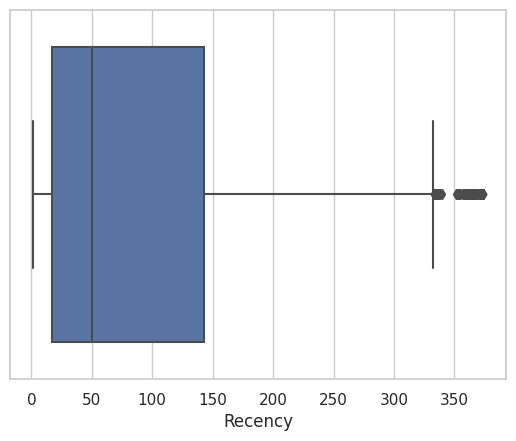

Frequency: 


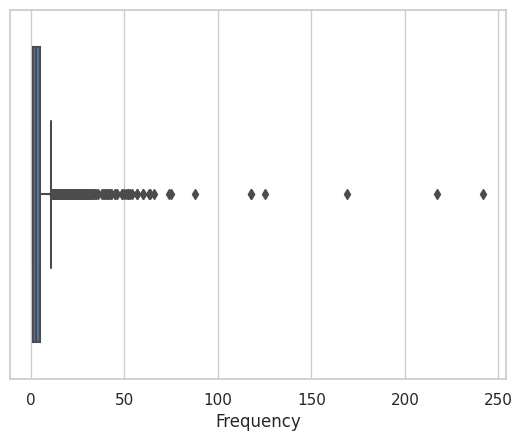

Monetary: 


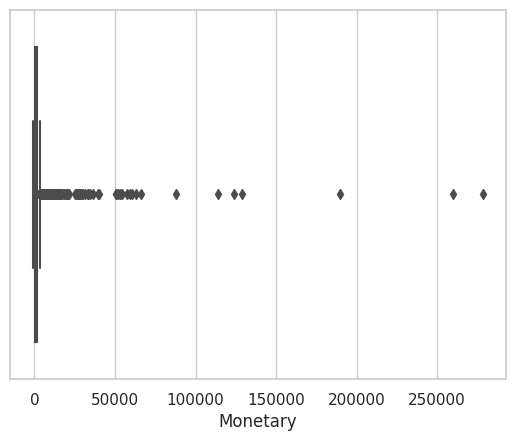

In [47]:
list1 = ['Recency','Frequency','Monetary']
for i in list1:
    print(str(i)+': ')
    ax = sns.boxplot(x=rfm_df[str(i)])
    plt.show()

In [48]:
new_df = rfm_df[['Recency','Frequency','Monetary']]
z_scores = stats.zscore(new_df)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
new_df = new_df[filtered_entries]

In [49]:
col_names = ['Recency','Frequency','Frequency']
features = new_df[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_features = pd.DataFrame(features, columns = col_names)

Text(0, 0.5, 'Inertia')

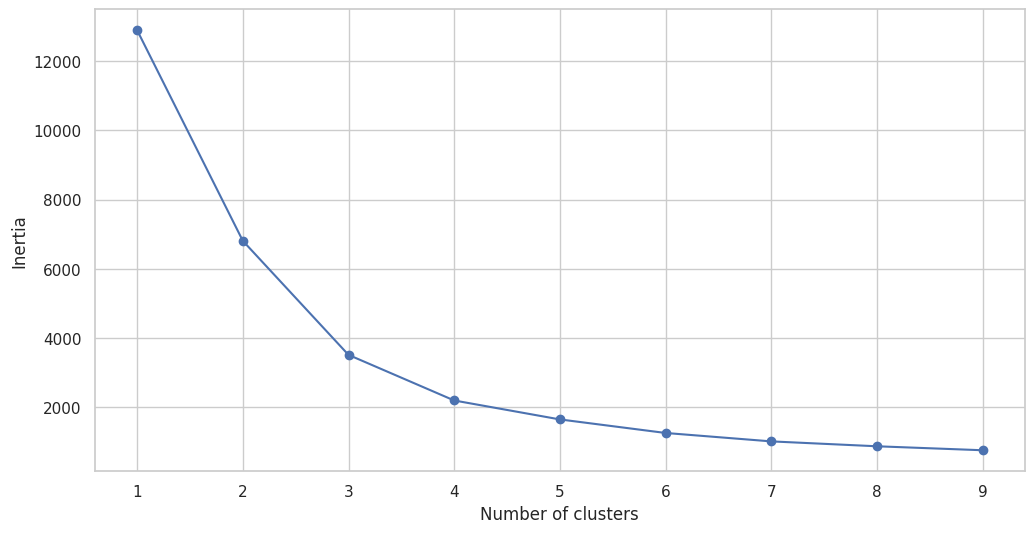

In [50]:
SSE = []
for cluster in range(1,10):
    kmeans = KMeans(n_clusters = cluster, init='k-means++')
    kmeans.fit(scaled_features)
    SSE.append(kmeans.inertia_)
# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,10), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [51]:
kmeans = KMeans( n_clusters = 4, init='k-means++')
kmeans.fit(scaled_features)

KMeans(n_clusters=4)

In [52]:
print(silhouette_score(scaled_features, kmeans.labels_, metric='euclidean'))


0.5309392828518759


In [53]:
pred = kmeans.predict(scaled_features)
frame = pd.DataFrame(new_df)
frame['cluster'] = pred

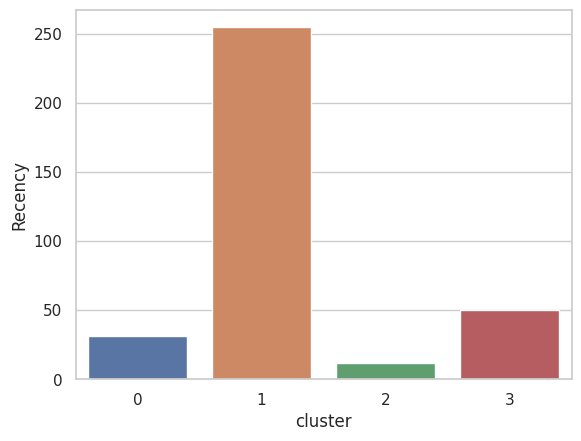

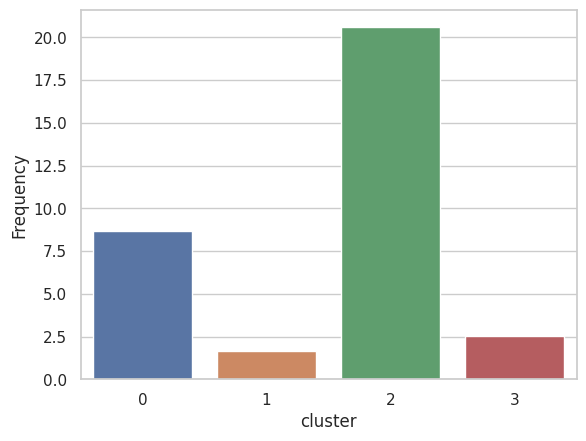

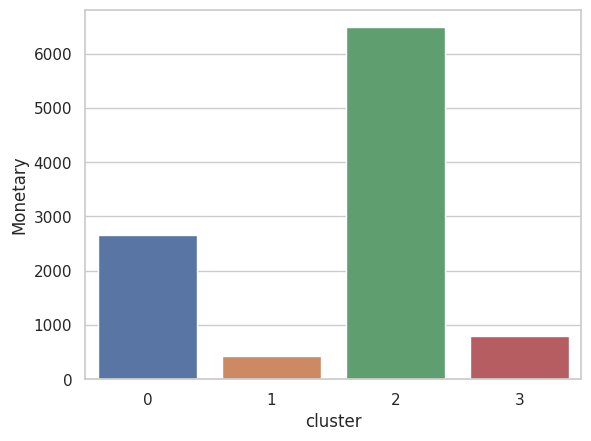

In [54]:
avg_df = frame.groupby(['cluster'], as_index=False).mean()
for i in list1:
    sns.barplot(x='cluster',y=str(i),data=avg_df)
    plt.show()